In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import fastai.vision as fv

In [5]:
df = pd.read_csv("data.csv", header=None)

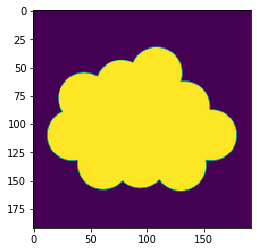

In [19]:
plt.imshow(plt.imread("Data/cloud/715094-200.png")); plt.show()

In [22]:
plt.imread("Data/cloud/715094-200.png").shape

(192, 192)

In [21]:
df[df[1] == "cloud"].head()

,0,1,2,3,4
4,14001,cloud,cloud/715094-200.png,daniela baptista,creative commons
59,14001,cloud,cloud/1472242-200.png,landan lloyd,creative commons
125,14001,cloud,cloud/923348-200.png,stonehub,creative commons
158,14001,cloud,cloud/1845412-200.png,smalllike,creative commons
1501,14001,cloud,cloud/890382-200.png,dev patel,creative commons


In [59]:
data = fv.ImageDataBunch.from_folder("Data/cloud/", valid_pct=.3, size=32, bs=1)

In [63]:
!pwd

/home/andrew/Documents/gans


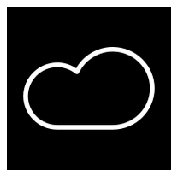

In [40]:
data.get(6).show(); plt.show()

In [52]:
for i in iter(data.train_dl):
    print(i[0].shape)
    break

torch.Size([64, 3, 32, 32])


In [62]:
n_epochs = 200
batch_size = 1
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu=8
latent_dim = 100
img_size = 32
channels = 3
sample_interval = 400

cuda = True if torch.cuda.is_available() else False

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity


# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
data = fv.ImageDataBunch.from_folder("Data/zucchini/", valid_pct=.3, size=32, bs=batch_size)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------

os.makedirs("images", exist_ok=True)
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(data.train_dl):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(data.train_dl), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(data.train_dl) + i
        if batches_done % sample_interval == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

[Epoch 0/200] [Batch 0/29] [D loss: 0.693161] [G loss: 0.702713]
[Epoch 0/200] [Batch 1/29] [D loss: 0.693052] [G loss: 0.702177]
[Epoch 0/200] [Batch 2/29] [D loss: 0.693052] [G loss: 0.701456]
[Epoch 0/200] [Batch 3/29] [D loss: 0.693352] [G loss: 0.700827]
[Epoch 0/200] [Batch 4/29] [D loss: 0.693156] [G loss: 0.699826]
[Epoch 0/200] [Batch 5/29] [D loss: 0.692806] [G loss: 0.699444]
[Epoch 0/200] [Batch 6/29] [D loss: 0.693061] [G loss: 0.698975]
[Epoch 0/200] [Batch 7/29] [D loss: 0.692995] [G loss: 0.698442]
[Epoch 0/200] [Batch 8/29] [D loss: 0.693095] [G loss: 0.697935]
[Epoch 0/200] [Batch 9/29] [D loss: 0.693136] [G loss: 0.697428]
[Epoch 0/200] [Batch 10/29] [D loss: 0.693230] [G loss: 0.697061]
[Epoch 0/200] [Batch 11/29] [D loss: 0.692913] [G loss: 0.696544]
[Epoch 0/200] [Batch 12/29] [D loss: 0.693070] [G loss: 0.696141]
[Epoch 0/200] [Batch 13/29] [D loss: 0.692809] [G loss: 0.695643]
[Epoch 0/200] [Batch 14/29] [D loss: 0.692960] [G loss: 0.695360]
[Epoch 0/200] [Batch

[Epoch 4/200] [Batch 12/29] [D loss: 0.692307] [G loss: 0.686806]
[Epoch 4/200] [Batch 13/29] [D loss: 0.686683] [G loss: 0.696237]
[Epoch 4/200] [Batch 14/29] [D loss: 0.695933] [G loss: 0.683716]
[Epoch 4/200] [Batch 15/29] [D loss: 0.707255] [G loss: 0.679950]
[Epoch 4/200] [Batch 16/29] [D loss: 0.686302] [G loss: 0.691460]
[Epoch 4/200] [Batch 17/29] [D loss: 0.695275] [G loss: 0.679179]
[Epoch 4/200] [Batch 18/29] [D loss: 0.697942] [G loss: 0.680155]
[Epoch 4/200] [Batch 19/29] [D loss: 0.699937] [G loss: 0.668317]
[Epoch 4/200] [Batch 20/29] [D loss: 0.703665] [G loss: 0.682307]
[Epoch 4/200] [Batch 21/29] [D loss: 0.704349] [G loss: 0.675067]
[Epoch 4/200] [Batch 22/29] [D loss: 0.694014] [G loss: 0.694292]
[Epoch 4/200] [Batch 23/29] [D loss: 0.694709] [G loss: 0.689539]
[Epoch 4/200] [Batch 24/29] [D loss: 0.691270] [G loss: 0.693460]
[Epoch 4/200] [Batch 25/29] [D loss: 0.694875] [G loss: 0.689897]
[Epoch 4/200] [Batch 26/29] [D loss: 0.694912] [G loss: 0.691267]
[Epoch 4/2

[Epoch 8/200] [Batch 23/29] [D loss: 0.697056] [G loss: 0.701059]
[Epoch 8/200] [Batch 24/29] [D loss: 0.673775] [G loss: 0.704716]
[Epoch 8/200] [Batch 25/29] [D loss: 0.758711] [G loss: 0.732366]
[Epoch 8/200] [Batch 26/29] [D loss: 0.713796] [G loss: 0.685595]
[Epoch 8/200] [Batch 27/29] [D loss: 0.720722] [G loss: 0.682783]
[Epoch 8/200] [Batch 28/29] [D loss: 0.717513] [G loss: 0.678955]
[Epoch 9/200] [Batch 0/29] [D loss: 0.686880] [G loss: 0.689394]
[Epoch 9/200] [Batch 1/29] [D loss: 0.694125] [G loss: 0.679257]
[Epoch 9/200] [Batch 2/29] [D loss: 0.688859] [G loss: 0.686305]
[Epoch 9/200] [Batch 3/29] [D loss: 0.686657] [G loss: 0.681671]
[Epoch 9/200] [Batch 4/29] [D loss: 0.687785] [G loss: 0.685215]
[Epoch 9/200] [Batch 5/29] [D loss: 0.708439] [G loss: 0.685508]
[Epoch 9/200] [Batch 6/29] [D loss: 0.704095] [G loss: 0.680890]
[Epoch 9/200] [Batch 7/29] [D loss: 0.676016] [G loss: 0.712511]
[Epoch 9/200] [Batch 8/29] [D loss: 0.690647] [G loss: 0.681746]
[Epoch 9/200] [Batc

[Epoch 13/200] [Batch 11/29] [D loss: 0.682834] [G loss: 0.713140]
[Epoch 13/200] [Batch 12/29] [D loss: 0.686960] [G loss: 0.707292]
[Epoch 13/200] [Batch 13/29] [D loss: 0.686118] [G loss: 0.700710]
[Epoch 13/200] [Batch 14/29] [D loss: 0.683709] [G loss: 0.692194]
[Epoch 13/200] [Batch 15/29] [D loss: 0.697022] [G loss: 0.701329]
[Epoch 13/200] [Batch 16/29] [D loss: 0.700692] [G loss: 0.693154]
[Epoch 13/200] [Batch 17/29] [D loss: 0.715602] [G loss: 0.691437]
[Epoch 13/200] [Batch 18/29] [D loss: 0.686163] [G loss: 0.694232]
[Epoch 13/200] [Batch 19/29] [D loss: 0.693494] [G loss: 0.683791]
[Epoch 13/200] [Batch 20/29] [D loss: 0.692905] [G loss: 0.707741]
[Epoch 13/200] [Batch 21/29] [D loss: 0.689176] [G loss: 0.705882]
[Epoch 13/200] [Batch 22/29] [D loss: 0.687429] [G loss: 0.709248]
[Epoch 13/200] [Batch 23/29] [D loss: 0.683039] [G loss: 0.697515]
[Epoch 13/200] [Batch 24/29] [D loss: 0.682254] [G loss: 0.704848]
[Epoch 13/200] [Batch 25/29] [D loss: 0.709143] [G loss: 0.703

[Epoch 17/200] [Batch 24/29] [D loss: 0.689488] [G loss: 0.691426]
[Epoch 17/200] [Batch 25/29] [D loss: 0.686690] [G loss: 0.688253]
[Epoch 17/200] [Batch 26/29] [D loss: 0.698871] [G loss: 0.694423]
[Epoch 17/200] [Batch 27/29] [D loss: 0.664398] [G loss: 0.706898]
[Epoch 17/200] [Batch 28/29] [D loss: 0.705072] [G loss: 0.674332]
[Epoch 18/200] [Batch 0/29] [D loss: 0.679142] [G loss: 0.685513]
[Epoch 18/200] [Batch 1/29] [D loss: 0.679691] [G loss: 0.684197]
[Epoch 18/200] [Batch 2/29] [D loss: 0.683466] [G loss: 0.694898]
[Epoch 18/200] [Batch 3/29] [D loss: 0.688503] [G loss: 0.671980]
[Epoch 18/200] [Batch 4/29] [D loss: 0.698017] [G loss: 0.688933]
[Epoch 18/200] [Batch 5/29] [D loss: 0.693404] [G loss: 0.708669]
[Epoch 18/200] [Batch 6/29] [D loss: 0.699133] [G loss: 0.708931]
[Epoch 18/200] [Batch 7/29] [D loss: 0.675792] [G loss: 0.703321]
[Epoch 18/200] [Batch 8/29] [D loss: 0.707816] [G loss: 0.703788]
[Epoch 18/200] [Batch 9/29] [D loss: 0.680130] [G loss: 0.722776]
[Epoc

[Epoch 22/200] [Batch 13/29] [D loss: 0.686986] [G loss: 0.664713]
[Epoch 22/200] [Batch 14/29] [D loss: 0.683051] [G loss: 0.700673]
[Epoch 22/200] [Batch 15/29] [D loss: 0.695232] [G loss: 0.632390]
[Epoch 22/200] [Batch 16/29] [D loss: 0.702404] [G loss: 0.705014]
[Epoch 22/200] [Batch 17/29] [D loss: 0.674156] [G loss: 0.649695]
[Epoch 22/200] [Batch 18/29] [D loss: 0.693600] [G loss: 0.691152]
[Epoch 22/200] [Batch 19/29] [D loss: 0.741521] [G loss: 0.669773]
[Epoch 22/200] [Batch 20/29] [D loss: 0.663350] [G loss: 0.676831]
[Epoch 22/200] [Batch 21/29] [D loss: 0.680286] [G loss: 0.713535]
[Epoch 22/200] [Batch 22/29] [D loss: 0.690903] [G loss: 0.688037]
[Epoch 22/200] [Batch 23/29] [D loss: 0.683008] [G loss: 0.730307]
[Epoch 22/200] [Batch 24/29] [D loss: 0.715471] [G loss: 0.727203]
[Epoch 22/200] [Batch 25/29] [D loss: 0.672219] [G loss: 0.737176]
[Epoch 22/200] [Batch 26/29] [D loss: 0.667015] [G loss: 0.726624]
[Epoch 22/200] [Batch 27/29] [D loss: 0.687328] [G loss: 0.724

[Epoch 26/200] [Batch 26/29] [D loss: 0.658866] [G loss: 0.674108]
[Epoch 26/200] [Batch 27/29] [D loss: 0.644885] [G loss: 0.761310]
[Epoch 26/200] [Batch 28/29] [D loss: 0.581514] [G loss: 0.717803]
[Epoch 27/200] [Batch 0/29] [D loss: 0.577562] [G loss: 0.989979]
[Epoch 27/200] [Batch 1/29] [D loss: 0.596573] [G loss: 0.727064]
[Epoch 27/200] [Batch 2/29] [D loss: 0.487959] [G loss: 0.973606]
[Epoch 27/200] [Batch 3/29] [D loss: 0.688838] [G loss: 0.635042]
[Epoch 27/200] [Batch 4/29] [D loss: 0.653293] [G loss: 0.772110]
[Epoch 27/200] [Batch 5/29] [D loss: 0.639433] [G loss: 0.722045]
[Epoch 27/200] [Batch 6/29] [D loss: 0.687515] [G loss: 0.609158]
[Epoch 27/200] [Batch 7/29] [D loss: 0.650241] [G loss: 0.657091]
[Epoch 27/200] [Batch 8/29] [D loss: 0.820951] [G loss: 0.520419]
[Epoch 27/200] [Batch 9/29] [D loss: 0.609500] [G loss: 0.657044]
[Epoch 27/200] [Batch 10/29] [D loss: 0.573987] [G loss: 0.570167]
[Epoch 27/200] [Batch 11/29] [D loss: 0.638081] [G loss: 0.689329]
[Epoc

[Epoch 31/200] [Batch 13/29] [D loss: 0.630584] [G loss: 0.626783]
[Epoch 31/200] [Batch 14/29] [D loss: 0.828838] [G loss: 0.601406]
[Epoch 31/200] [Batch 15/29] [D loss: 0.715754] [G loss: 0.637509]
[Epoch 31/200] [Batch 16/29] [D loss: 0.731300] [G loss: 0.653517]
[Epoch 31/200] [Batch 17/29] [D loss: 0.659281] [G loss: 0.685188]
[Epoch 31/200] [Batch 18/29] [D loss: 0.757465] [G loss: 0.709927]
[Epoch 31/200] [Batch 19/29] [D loss: 0.636056] [G loss: 0.653785]
[Epoch 31/200] [Batch 20/29] [D loss: 0.657954] [G loss: 0.579926]
[Epoch 31/200] [Batch 21/29] [D loss: 0.724696] [G loss: 0.721748]
[Epoch 31/200] [Batch 22/29] [D loss: 0.709188] [G loss: 0.674559]
[Epoch 31/200] [Batch 23/29] [D loss: 0.669629] [G loss: 0.668420]
[Epoch 31/200] [Batch 24/29] [D loss: 0.543432] [G loss: 0.810718]
[Epoch 31/200] [Batch 25/29] [D loss: 0.591566] [G loss: 0.801865]
[Epoch 31/200] [Batch 26/29] [D loss: 0.655364] [G loss: 0.700142]
[Epoch 31/200] [Batch 27/29] [D loss: 0.594279] [G loss: 0.734

[Epoch 35/200] [Batch 25/29] [D loss: 0.598198] [G loss: 0.702359]
[Epoch 35/200] [Batch 26/29] [D loss: 0.545279] [G loss: 0.656031]
[Epoch 35/200] [Batch 27/29] [D loss: 0.775262] [G loss: 0.747982]
[Epoch 35/200] [Batch 28/29] [D loss: 0.659693] [G loss: 0.522196]
[Epoch 36/200] [Batch 0/29] [D loss: 0.798083] [G loss: 0.685049]
[Epoch 36/200] [Batch 1/29] [D loss: 0.418940] [G loss: 0.785800]
[Epoch 36/200] [Batch 2/29] [D loss: 0.695225] [G loss: 0.786065]
[Epoch 36/200] [Batch 3/29] [D loss: 0.577129] [G loss: 0.595103]
[Epoch 36/200] [Batch 4/29] [D loss: 0.591710] [G loss: 0.719091]
[Epoch 36/200] [Batch 5/29] [D loss: 0.550874] [G loss: 0.975917]
[Epoch 36/200] [Batch 6/29] [D loss: 0.600652] [G loss: 0.819417]
[Epoch 36/200] [Batch 7/29] [D loss: 0.484957] [G loss: 0.966929]
[Epoch 36/200] [Batch 8/29] [D loss: 0.576444] [G loss: 0.696800]
[Epoch 36/200] [Batch 9/29] [D loss: 0.732637] [G loss: 0.774023]
[Epoch 36/200] [Batch 10/29] [D loss: 0.704693] [G loss: 0.656046]
[Epoc

[Epoch 40/200] [Batch 11/29] [D loss: 0.427265] [G loss: 0.901791]
[Epoch 40/200] [Batch 12/29] [D loss: 0.569748] [G loss: 0.834377]
[Epoch 40/200] [Batch 13/29] [D loss: 0.644044] [G loss: 0.940131]
[Epoch 40/200] [Batch 14/29] [D loss: 0.440797] [G loss: 0.640268]
[Epoch 40/200] [Batch 15/29] [D loss: 0.575680] [G loss: 0.892834]
[Epoch 40/200] [Batch 16/29] [D loss: 0.812042] [G loss: 0.812505]
[Epoch 40/200] [Batch 17/29] [D loss: 0.601809] [G loss: 0.906605]
[Epoch 40/200] [Batch 18/29] [D loss: 0.354714] [G loss: 0.801988]
[Epoch 40/200] [Batch 19/29] [D loss: 0.485438] [G loss: 0.604084]
[Epoch 40/200] [Batch 20/29] [D loss: 0.433116] [G loss: 0.987743]
[Epoch 40/200] [Batch 21/29] [D loss: 0.610910] [G loss: 0.669402]
[Epoch 40/200] [Batch 22/29] [D loss: 0.633748] [G loss: 1.269733]
[Epoch 40/200] [Batch 23/29] [D loss: 0.665233] [G loss: 0.494015]
[Epoch 40/200] [Batch 24/29] [D loss: 0.429944] [G loss: 1.137268]
[Epoch 40/200] [Batch 25/29] [D loss: 0.681254] [G loss: 0.844

[Epoch 44/200] [Batch 24/29] [D loss: 0.490681] [G loss: 0.630403]
[Epoch 44/200] [Batch 25/29] [D loss: 0.658092] [G loss: 1.142930]
[Epoch 44/200] [Batch 26/29] [D loss: 0.862160] [G loss: 0.647359]
[Epoch 44/200] [Batch 27/29] [D loss: 0.578838] [G loss: 0.862297]
[Epoch 44/200] [Batch 28/29] [D loss: 0.470856] [G loss: 0.868656]
[Epoch 45/200] [Batch 0/29] [D loss: 0.589240] [G loss: 1.295454]
[Epoch 45/200] [Batch 1/29] [D loss: 0.562735] [G loss: 0.968541]
[Epoch 45/200] [Batch 2/29] [D loss: 0.890265] [G loss: 1.976277]
[Epoch 45/200] [Batch 3/29] [D loss: 0.553915] [G loss: 1.072492]
[Epoch 45/200] [Batch 4/29] [D loss: 0.433963] [G loss: 0.923224]
[Epoch 45/200] [Batch 5/29] [D loss: 0.744424] [G loss: 1.117686]
[Epoch 45/200] [Batch 6/29] [D loss: 0.497416] [G loss: 0.831825]
[Epoch 45/200] [Batch 7/29] [D loss: 0.678921] [G loss: 1.466182]
[Epoch 45/200] [Batch 8/29] [D loss: 0.850551] [G loss: 0.705440]
[Epoch 45/200] [Batch 9/29] [D loss: 0.717795] [G loss: 0.538935]
[Epoc

[Epoch 49/200] [Batch 11/29] [D loss: 0.445422] [G loss: 0.859857]
[Epoch 49/200] [Batch 12/29] [D loss: 0.670821] [G loss: 1.175828]
[Epoch 49/200] [Batch 13/29] [D loss: 0.383520] [G loss: 2.190370]
[Epoch 49/200] [Batch 14/29] [D loss: 0.439813] [G loss: 0.632245]
[Epoch 49/200] [Batch 15/29] [D loss: 1.048175] [G loss: 0.824884]
[Epoch 49/200] [Batch 16/29] [D loss: 0.849761] [G loss: 0.852488]
[Epoch 49/200] [Batch 17/29] [D loss: 0.622571] [G loss: 0.875330]
[Epoch 49/200] [Batch 18/29] [D loss: 0.405961] [G loss: 1.486426]
[Epoch 49/200] [Batch 19/29] [D loss: 0.253235] [G loss: 2.319245]
[Epoch 49/200] [Batch 20/29] [D loss: 0.741747] [G loss: 0.890762]
[Epoch 49/200] [Batch 21/29] [D loss: 0.663133] [G loss: 0.422262]
[Epoch 49/200] [Batch 22/29] [D loss: 0.749315] [G loss: 1.727656]
[Epoch 49/200] [Batch 23/29] [D loss: 0.492913] [G loss: 0.666214]
[Epoch 49/200] [Batch 24/29] [D loss: 0.489276] [G loss: 0.752504]
[Epoch 49/200] [Batch 25/29] [D loss: 0.475879] [G loss: 0.620

[Epoch 53/200] [Batch 24/29] [D loss: 0.806716] [G loss: 1.196411]
[Epoch 53/200] [Batch 25/29] [D loss: 0.520631] [G loss: 0.783678]
[Epoch 53/200] [Batch 26/29] [D loss: 1.383145] [G loss: 0.311576]
[Epoch 53/200] [Batch 27/29] [D loss: 0.276473] [G loss: 2.380328]
[Epoch 53/200] [Batch 28/29] [D loss: 0.868923] [G loss: 0.887961]
[Epoch 54/200] [Batch 0/29] [D loss: 0.297060] [G loss: 1.115818]
[Epoch 54/200] [Batch 1/29] [D loss: 0.695389] [G loss: 0.330814]
[Epoch 54/200] [Batch 2/29] [D loss: 0.433947] [G loss: 1.136544]
[Epoch 54/200] [Batch 3/29] [D loss: 0.801289] [G loss: 1.470653]
[Epoch 54/200] [Batch 4/29] [D loss: 0.303415] [G loss: 1.515260]
[Epoch 54/200] [Batch 5/29] [D loss: 0.390367] [G loss: 0.980245]
[Epoch 54/200] [Batch 6/29] [D loss: 0.201496] [G loss: 1.844221]
[Epoch 54/200] [Batch 7/29] [D loss: 0.180197] [G loss: 2.011657]
[Epoch 54/200] [Batch 8/29] [D loss: 0.412163] [G loss: 0.999030]
[Epoch 54/200] [Batch 9/29] [D loss: 0.366297] [G loss: 1.370561]
[Epoc

[Epoch 58/200] [Batch 12/29] [D loss: 0.311071] [G loss: 0.718162]
[Epoch 58/200] [Batch 13/29] [D loss: 0.593916] [G loss: 1.726117]
[Epoch 58/200] [Batch 14/29] [D loss: 0.240601] [G loss: 1.526341]
[Epoch 58/200] [Batch 15/29] [D loss: 0.394517] [G loss: 1.856895]
[Epoch 58/200] [Batch 16/29] [D loss: 0.499999] [G loss: 2.360080]
[Epoch 58/200] [Batch 17/29] [D loss: 0.409994] [G loss: 1.881941]
[Epoch 58/200] [Batch 18/29] [D loss: 0.776946] [G loss: 0.381763]
[Epoch 58/200] [Batch 19/29] [D loss: 0.449165] [G loss: 0.573237]
[Epoch 58/200] [Batch 20/29] [D loss: 0.607400] [G loss: 0.808479]
[Epoch 58/200] [Batch 21/29] [D loss: 0.759692] [G loss: 1.605651]
[Epoch 58/200] [Batch 22/29] [D loss: 0.210082] [G loss: 1.966845]
[Epoch 58/200] [Batch 23/29] [D loss: 0.580726] [G loss: 2.140473]
[Epoch 58/200] [Batch 24/29] [D loss: 0.443418] [G loss: 2.904428]
[Epoch 58/200] [Batch 25/29] [D loss: 0.330526] [G loss: 1.187053]
[Epoch 58/200] [Batch 26/29] [D loss: 0.103821] [G loss: 0.980

[Epoch 62/200] [Batch 24/29] [D loss: 0.412552] [G loss: 1.298477]
[Epoch 62/200] [Batch 25/29] [D loss: 0.292095] [G loss: 2.138186]
[Epoch 62/200] [Batch 26/29] [D loss: 1.086438] [G loss: 0.836114]
[Epoch 62/200] [Batch 27/29] [D loss: 0.387413] [G loss: 0.348477]
[Epoch 62/200] [Batch 28/29] [D loss: 0.362306] [G loss: 1.818398]
[Epoch 63/200] [Batch 0/29] [D loss: 0.344118] [G loss: 0.680087]
[Epoch 63/200] [Batch 1/29] [D loss: 0.724178] [G loss: 0.463702]
[Epoch 63/200] [Batch 2/29] [D loss: 0.512042] [G loss: 1.435090]
[Epoch 63/200] [Batch 3/29] [D loss: 0.175801] [G loss: 1.335669]
[Epoch 63/200] [Batch 4/29] [D loss: 0.996429] [G loss: 1.149689]
[Epoch 63/200] [Batch 5/29] [D loss: 0.409930] [G loss: 0.138157]
[Epoch 63/200] [Batch 6/29] [D loss: 0.339518] [G loss: 0.647742]
[Epoch 63/200] [Batch 7/29] [D loss: 0.334957] [G loss: 3.379491]
[Epoch 63/200] [Batch 8/29] [D loss: 0.271790] [G loss: 2.106433]
[Epoch 63/200] [Batch 9/29] [D loss: 0.477743] [G loss: 1.152463]
[Epoc

[Epoch 67/200] [Batch 11/29] [D loss: 0.117078] [G loss: 1.477425]
[Epoch 67/200] [Batch 12/29] [D loss: 0.251449] [G loss: 1.156194]
[Epoch 67/200] [Batch 13/29] [D loss: 0.518220] [G loss: 3.496782]
[Epoch 67/200] [Batch 14/29] [D loss: 0.504094] [G loss: 1.150231]
[Epoch 67/200] [Batch 15/29] [D loss: 0.383326] [G loss: 0.737063]
[Epoch 67/200] [Batch 16/29] [D loss: 0.288249] [G loss: 2.266038]
[Epoch 67/200] [Batch 17/29] [D loss: 0.175349] [G loss: 1.716920]
[Epoch 67/200] [Batch 18/29] [D loss: 0.341745] [G loss: 0.715015]
[Epoch 67/200] [Batch 19/29] [D loss: 0.734899] [G loss: 1.262031]
[Epoch 67/200] [Batch 20/29] [D loss: 0.088420] [G loss: 1.510163]
[Epoch 67/200] [Batch 21/29] [D loss: 0.313224] [G loss: 1.716599]
[Epoch 67/200] [Batch 22/29] [D loss: 0.408569] [G loss: 1.138564]
[Epoch 67/200] [Batch 23/29] [D loss: 0.572682] [G loss: 1.457510]
[Epoch 67/200] [Batch 24/29] [D loss: 0.227708] [G loss: 0.921870]
[Epoch 67/200] [Batch 25/29] [D loss: 0.355547] [G loss: 1.134

[Epoch 71/200] [Batch 25/29] [D loss: 0.299026] [G loss: 0.995965]
[Epoch 71/200] [Batch 26/29] [D loss: 0.464593] [G loss: 2.129349]
[Epoch 71/200] [Batch 27/29] [D loss: 0.217549] [G loss: 1.430033]
[Epoch 71/200] [Batch 28/29] [D loss: 0.246133] [G loss: 1.404289]
[Epoch 72/200] [Batch 0/29] [D loss: 0.488132] [G loss: 0.541963]
[Epoch 72/200] [Batch 1/29] [D loss: 0.537486] [G loss: 1.340684]
[Epoch 72/200] [Batch 2/29] [D loss: 0.165604] [G loss: 0.609152]
[Epoch 72/200] [Batch 3/29] [D loss: 0.390764] [G loss: 1.129138]
[Epoch 72/200] [Batch 4/29] [D loss: 0.533295] [G loss: 2.947429]
[Epoch 72/200] [Batch 5/29] [D loss: 0.205268] [G loss: 2.843011]
[Epoch 72/200] [Batch 6/29] [D loss: 0.126540] [G loss: 2.056280]
[Epoch 72/200] [Batch 7/29] [D loss: 0.491620] [G loss: 0.488074]
[Epoch 72/200] [Batch 8/29] [D loss: 0.137181] [G loss: 1.299633]
[Epoch 72/200] [Batch 9/29] [D loss: 0.481826] [G loss: 0.731142]
[Epoch 72/200] [Batch 10/29] [D loss: 0.303242] [G loss: 1.782231]
[Epoc

[Epoch 76/200] [Batch 12/29] [D loss: 0.127774] [G loss: 0.474247]
[Epoch 76/200] [Batch 13/29] [D loss: 0.320338] [G loss: 1.524018]
[Epoch 76/200] [Batch 14/29] [D loss: 0.444885] [G loss: 0.802177]
[Epoch 76/200] [Batch 15/29] [D loss: 0.413436] [G loss: 1.175946]
[Epoch 76/200] [Batch 16/29] [D loss: 0.696905] [G loss: 0.933379]
[Epoch 76/200] [Batch 17/29] [D loss: 0.554314] [G loss: 2.801235]
[Epoch 76/200] [Batch 18/29] [D loss: 0.160899] [G loss: 1.328370]
[Epoch 76/200] [Batch 19/29] [D loss: 0.276560] [G loss: 1.609505]
[Epoch 76/200] [Batch 20/29] [D loss: 0.459481] [G loss: 1.619673]
[Epoch 76/200] [Batch 21/29] [D loss: 0.198377] [G loss: 2.803524]
[Epoch 76/200] [Batch 22/29] [D loss: 0.491348] [G loss: 1.882132]
[Epoch 76/200] [Batch 23/29] [D loss: 0.878838] [G loss: 0.633621]
[Epoch 76/200] [Batch 24/29] [D loss: 0.392487] [G loss: 1.877453]
[Epoch 76/200] [Batch 25/29] [D loss: 0.254250] [G loss: 2.858572]
[Epoch 76/200] [Batch 26/29] [D loss: 0.323665] [G loss: 2.073

[Epoch 80/200] [Batch 25/29] [D loss: 0.299443] [G loss: 0.645872]
[Epoch 80/200] [Batch 26/29] [D loss: 0.038403] [G loss: 2.092559]
[Epoch 80/200] [Batch 27/29] [D loss: 0.646403] [G loss: 1.741612]
[Epoch 80/200] [Batch 28/29] [D loss: 0.433164] [G loss: 2.825701]
[Epoch 81/200] [Batch 0/29] [D loss: 0.323783] [G loss: 1.448466]
[Epoch 81/200] [Batch 1/29] [D loss: 0.329233] [G loss: 2.845850]
[Epoch 81/200] [Batch 2/29] [D loss: 0.356479] [G loss: 2.300789]
[Epoch 81/200] [Batch 3/29] [D loss: 0.746519] [G loss: 1.247118]
[Epoch 81/200] [Batch 4/29] [D loss: 0.276805] [G loss: 2.040815]
[Epoch 81/200] [Batch 5/29] [D loss: 0.935028] [G loss: 1.984272]
[Epoch 81/200] [Batch 6/29] [D loss: 0.162782] [G loss: 0.717077]
[Epoch 81/200] [Batch 7/29] [D loss: 0.530862] [G loss: 0.930986]
[Epoch 81/200] [Batch 8/29] [D loss: 0.338877] [G loss: 0.881094]
[Epoch 81/200] [Batch 9/29] [D loss: 0.440056] [G loss: 0.095700]
[Epoch 81/200] [Batch 10/29] [D loss: 0.274663] [G loss: 1.674427]
[Epoc

[Epoch 85/200] [Batch 12/29] [D loss: 0.292632] [G loss: 0.724864]
[Epoch 85/200] [Batch 13/29] [D loss: 0.583892] [G loss: 1.482984]
[Epoch 85/200] [Batch 14/29] [D loss: 0.510334] [G loss: 1.461099]
[Epoch 85/200] [Batch 15/29] [D loss: 0.186922] [G loss: 1.373948]
[Epoch 85/200] [Batch 16/29] [D loss: 0.300652] [G loss: 0.918357]
[Epoch 85/200] [Batch 17/29] [D loss: 0.161812] [G loss: 1.933385]
[Epoch 85/200] [Batch 18/29] [D loss: 0.381777] [G loss: 0.779544]
[Epoch 85/200] [Batch 19/29] [D loss: 0.199740] [G loss: 2.402620]
[Epoch 85/200] [Batch 20/29] [D loss: 0.831683] [G loss: 1.127901]
[Epoch 85/200] [Batch 21/29] [D loss: 0.483077] [G loss: 1.197838]
[Epoch 85/200] [Batch 22/29] [D loss: 0.188463] [G loss: 3.771920]
[Epoch 85/200] [Batch 23/29] [D loss: 0.354196] [G loss: 3.653435]
[Epoch 85/200] [Batch 24/29] [D loss: 0.290666] [G loss: 1.404870]
[Epoch 85/200] [Batch 25/29] [D loss: 1.163747] [G loss: 2.328300]
[Epoch 85/200] [Batch 26/29] [D loss: 0.249594] [G loss: 1.322

[Epoch 89/200] [Batch 25/29] [D loss: 0.400826] [G loss: 0.534619]
[Epoch 89/200] [Batch 26/29] [D loss: 0.058054] [G loss: 1.664357]
[Epoch 89/200] [Batch 27/29] [D loss: 0.168038] [G loss: 0.975357]
[Epoch 89/200] [Batch 28/29] [D loss: 0.274215] [G loss: 1.518906]
[Epoch 90/200] [Batch 0/29] [D loss: 0.272540] [G loss: 1.791316]
[Epoch 90/200] [Batch 1/29] [D loss: 0.174998] [G loss: 1.147700]
[Epoch 90/200] [Batch 2/29] [D loss: 0.171329] [G loss: 2.145612]
[Epoch 90/200] [Batch 3/29] [D loss: 0.983028] [G loss: 0.174157]
[Epoch 90/200] [Batch 4/29] [D loss: 0.765736] [G loss: 0.430368]
[Epoch 90/200] [Batch 5/29] [D loss: 0.096166] [G loss: 3.334041]
[Epoch 90/200] [Batch 6/29] [D loss: 0.036560] [G loss: 1.798427]
[Epoch 90/200] [Batch 7/29] [D loss: 0.446766] [G loss: 2.639485]
[Epoch 90/200] [Batch 8/29] [D loss: 0.130510] [G loss: 1.811051]
[Epoch 90/200] [Batch 9/29] [D loss: 0.345196] [G loss: 0.980774]
[Epoch 90/200] [Batch 10/29] [D loss: 0.589215] [G loss: 3.808757]
[Epoc

[Epoch 94/200] [Batch 14/29] [D loss: 0.214211] [G loss: 1.143237]
[Epoch 94/200] [Batch 15/29] [D loss: 0.096057] [G loss: 1.888662]
[Epoch 94/200] [Batch 16/29] [D loss: 0.508873] [G loss: 0.436564]
[Epoch 94/200] [Batch 17/29] [D loss: 1.003326] [G loss: 1.494255]
[Epoch 94/200] [Batch 18/29] [D loss: 0.073899] [G loss: 0.721614]
[Epoch 94/200] [Batch 19/29] [D loss: 0.406841] [G loss: 0.805247]
[Epoch 94/200] [Batch 20/29] [D loss: 0.268932] [G loss: 3.469088]
[Epoch 94/200] [Batch 21/29] [D loss: 0.058531] [G loss: 1.991571]
[Epoch 94/200] [Batch 22/29] [D loss: 0.754640] [G loss: 0.747530]
[Epoch 94/200] [Batch 23/29] [D loss: 0.247554] [G loss: 1.185500]
[Epoch 94/200] [Batch 24/29] [D loss: 0.126821] [G loss: 1.425814]
[Epoch 94/200] [Batch 25/29] [D loss: 0.561837] [G loss: 0.654683]
[Epoch 94/200] [Batch 26/29] [D loss: 0.553254] [G loss: 3.296755]
[Epoch 94/200] [Batch 27/29] [D loss: 0.130057] [G loss: 0.894379]
[Epoch 94/200] [Batch 28/29] [D loss: 0.132715] [G loss: 1.193

[Epoch 98/200] [Batch 24/29] [D loss: 0.655656] [G loss: 2.410403]
[Epoch 98/200] [Batch 25/29] [D loss: 0.060765] [G loss: 2.783602]
[Epoch 98/200] [Batch 26/29] [D loss: 0.146928] [G loss: 1.953893]
[Epoch 98/200] [Batch 27/29] [D loss: 0.356523] [G loss: 3.475630]
[Epoch 98/200] [Batch 28/29] [D loss: 0.137886] [G loss: 1.341809]
[Epoch 99/200] [Batch 0/29] [D loss: 1.148633] [G loss: 0.999683]
[Epoch 99/200] [Batch 1/29] [D loss: 0.235711] [G loss: 0.672252]
[Epoch 99/200] [Batch 2/29] [D loss: 0.119665] [G loss: 0.109275]
[Epoch 99/200] [Batch 3/29] [D loss: 0.206162] [G loss: 6.416171]
[Epoch 99/200] [Batch 4/29] [D loss: 0.550702] [G loss: 1.346379]
[Epoch 99/200] [Batch 5/29] [D loss: 0.128833] [G loss: 2.363616]
[Epoch 99/200] [Batch 6/29] [D loss: 0.422045] [G loss: 2.497491]
[Epoch 99/200] [Batch 7/29] [D loss: 0.183837] [G loss: 3.715141]
[Epoch 99/200] [Batch 8/29] [D loss: 0.038291] [G loss: 2.290000]
[Epoch 99/200] [Batch 9/29] [D loss: 0.290344] [G loss: 0.824561]
[Epoc

[Epoch 103/200] [Batch 12/29] [D loss: 0.086278] [G loss: 3.083461]
[Epoch 103/200] [Batch 13/29] [D loss: 0.777391] [G loss: 1.681569]
[Epoch 103/200] [Batch 14/29] [D loss: 0.821283] [G loss: 0.762592]
[Epoch 103/200] [Batch 15/29] [D loss: 1.844944] [G loss: 0.917242]
[Epoch 103/200] [Batch 16/29] [D loss: 0.601762] [G loss: 1.697366]
[Epoch 103/200] [Batch 17/29] [D loss: 0.575833] [G loss: 0.239701]
[Epoch 103/200] [Batch 18/29] [D loss: 0.291660] [G loss: 1.246125]
[Epoch 103/200] [Batch 19/29] [D loss: 0.123743] [G loss: 1.639763]
[Epoch 103/200] [Batch 20/29] [D loss: 0.423771] [G loss: 0.927572]
[Epoch 103/200] [Batch 21/29] [D loss: 0.586830] [G loss: 1.532781]
[Epoch 103/200] [Batch 22/29] [D loss: 0.341794] [G loss: 2.875148]
[Epoch 103/200] [Batch 23/29] [D loss: 0.229272] [G loss: 3.278098]
[Epoch 103/200] [Batch 24/29] [D loss: 0.403182] [G loss: 1.801251]
[Epoch 103/200] [Batch 25/29] [D loss: 1.124660] [G loss: 0.258042]
[Epoch 103/200] [Batch 26/29] [D loss: 0.440205]

[Epoch 107/200] [Batch 23/29] [D loss: 0.364543] [G loss: 1.205092]
[Epoch 107/200] [Batch 24/29] [D loss: 0.435305] [G loss: 1.010782]
[Epoch 107/200] [Batch 25/29] [D loss: 0.176882] [G loss: 1.945989]
[Epoch 107/200] [Batch 26/29] [D loss: 0.466623] [G loss: 0.609056]
[Epoch 107/200] [Batch 27/29] [D loss: 0.237026] [G loss: 0.958703]
[Epoch 107/200] [Batch 28/29] [D loss: 0.196661] [G loss: 0.804815]
[Epoch 108/200] [Batch 0/29] [D loss: 0.157425] [G loss: 3.050661]
[Epoch 108/200] [Batch 1/29] [D loss: 0.139371] [G loss: 3.256223]
[Epoch 108/200] [Batch 2/29] [D loss: 0.318654] [G loss: 2.327509]
[Epoch 108/200] [Batch 3/29] [D loss: 0.127026] [G loss: 3.383699]
[Epoch 108/200] [Batch 4/29] [D loss: 0.055030] [G loss: 2.391561]
[Epoch 108/200] [Batch 5/29] [D loss: 0.158022] [G loss: 0.807415]
[Epoch 108/200] [Batch 6/29] [D loss: 0.058665] [G loss: 2.738459]
[Epoch 108/200] [Batch 7/29] [D loss: 0.080701] [G loss: 2.472204]
[Epoch 108/200] [Batch 8/29] [D loss: 0.099697] [G loss:

[Epoch 112/200] [Batch 0/29] [D loss: 0.714794] [G loss: 1.087867]
[Epoch 112/200] [Batch 1/29] [D loss: 0.511574] [G loss: 0.694823]
[Epoch 112/200] [Batch 2/29] [D loss: 0.040290] [G loss: 3.694538]
[Epoch 112/200] [Batch 3/29] [D loss: 0.711030] [G loss: 1.927631]
[Epoch 112/200] [Batch 4/29] [D loss: 0.412549] [G loss: 1.272437]
[Epoch 112/200] [Batch 5/29] [D loss: 0.577986] [G loss: 3.500777]
[Epoch 112/200] [Batch 6/29] [D loss: 0.311107] [G loss: 1.583102]
[Epoch 112/200] [Batch 7/29] [D loss: 0.175067] [G loss: 0.941049]
[Epoch 112/200] [Batch 8/29] [D loss: 0.105377] [G loss: 0.905667]
[Epoch 112/200] [Batch 9/29] [D loss: 0.176886] [G loss: 1.484965]
[Epoch 112/200] [Batch 10/29] [D loss: 0.096128] [G loss: 1.168144]
[Epoch 112/200] [Batch 11/29] [D loss: 0.213185] [G loss: 3.825172]
[Epoch 112/200] [Batch 12/29] [D loss: 0.795966] [G loss: 1.284819]
[Epoch 112/200] [Batch 13/29] [D loss: 0.082944] [G loss: 1.585889]
[Epoch 112/200] [Batch 14/29] [D loss: 0.149442] [G loss: 

[Epoch 116/200] [Batch 11/29] [D loss: 0.277083] [G loss: 1.288506]
[Epoch 116/200] [Batch 12/29] [D loss: 0.601154] [G loss: 1.636943]
[Epoch 116/200] [Batch 13/29] [D loss: 0.139545] [G loss: 2.864013]
[Epoch 116/200] [Batch 14/29] [D loss: 0.196673] [G loss: 2.760319]
[Epoch 116/200] [Batch 15/29] [D loss: 0.056046] [G loss: 3.161283]
[Epoch 116/200] [Batch 16/29] [D loss: 0.167286] [G loss: 1.423249]
[Epoch 116/200] [Batch 17/29] [D loss: 1.081844] [G loss: 0.819976]
[Epoch 116/200] [Batch 18/29] [D loss: 0.776871] [G loss: 1.596271]
[Epoch 116/200] [Batch 19/29] [D loss: 0.420307] [G loss: 1.476476]
[Epoch 116/200] [Batch 20/29] [D loss: 0.415671] [G loss: 3.410401]
[Epoch 116/200] [Batch 21/29] [D loss: 0.176799] [G loss: 1.120982]
[Epoch 116/200] [Batch 22/29] [D loss: 0.016207] [G loss: 3.363970]
[Epoch 116/200] [Batch 23/29] [D loss: 0.538256] [G loss: 0.582035]
[Epoch 116/200] [Batch 24/29] [D loss: 0.117599] [G loss: 1.131384]
[Epoch 116/200] [Batch 25/29] [D loss: 0.214940]

[Epoch 120/200] [Batch 24/29] [D loss: 0.027174] [G loss: 1.734220]
[Epoch 120/200] [Batch 25/29] [D loss: 0.343696] [G loss: 1.053465]
[Epoch 120/200] [Batch 26/29] [D loss: 0.212765] [G loss: 2.042970]
[Epoch 120/200] [Batch 27/29] [D loss: 0.986669] [G loss: 2.311169]
[Epoch 120/200] [Batch 28/29] [D loss: 0.464476] [G loss: 1.795655]
[Epoch 121/200] [Batch 0/29] [D loss: 0.060255] [G loss: 2.172624]
[Epoch 121/200] [Batch 1/29] [D loss: 0.099327] [G loss: 3.460034]
[Epoch 121/200] [Batch 2/29] [D loss: 0.575211] [G loss: 2.899867]
[Epoch 121/200] [Batch 3/29] [D loss: 0.255040] [G loss: 4.486454]
[Epoch 121/200] [Batch 4/29] [D loss: 0.860507] [G loss: 3.067407]
[Epoch 121/200] [Batch 5/29] [D loss: 0.147552] [G loss: 1.459115]
[Epoch 121/200] [Batch 6/29] [D loss: 0.394326] [G loss: 0.608257]
[Epoch 121/200] [Batch 7/29] [D loss: 0.478167] [G loss: 0.846762]
[Epoch 121/200] [Batch 8/29] [D loss: 0.111865] [G loss: 2.829985]
[Epoch 121/200] [Batch 9/29] [D loss: 0.070389] [G loss: 

[Epoch 125/200] [Batch 11/29] [D loss: 0.081892] [G loss: 4.753629]
[Epoch 125/200] [Batch 12/29] [D loss: 0.542316] [G loss: 2.397820]
[Epoch 125/200] [Batch 13/29] [D loss: 0.043391] [G loss: 2.761998]
[Epoch 125/200] [Batch 14/29] [D loss: 0.045914] [G loss: 3.012109]
[Epoch 125/200] [Batch 15/29] [D loss: 0.829387] [G loss: 2.339421]
[Epoch 125/200] [Batch 16/29] [D loss: 0.107278] [G loss: 0.718613]
[Epoch 125/200] [Batch 17/29] [D loss: 0.411895] [G loss: 1.976612]
[Epoch 125/200] [Batch 18/29] [D loss: 0.098887] [G loss: 2.662741]
[Epoch 125/200] [Batch 19/29] [D loss: 0.276248] [G loss: 2.089562]
[Epoch 125/200] [Batch 20/29] [D loss: 0.117217] [G loss: 3.933789]
[Epoch 125/200] [Batch 21/29] [D loss: 0.285191] [G loss: 0.604651]
[Epoch 125/200] [Batch 22/29] [D loss: 0.170694] [G loss: 1.733039]
[Epoch 125/200] [Batch 23/29] [D loss: 0.082529] [G loss: 2.443197]
[Epoch 125/200] [Batch 24/29] [D loss: 0.153458] [G loss: 2.823792]
[Epoch 125/200] [Batch 25/29] [D loss: 0.293539]

[Epoch 129/200] [Batch 22/29] [D loss: 0.105446] [G loss: 1.389152]
[Epoch 129/200] [Batch 23/29] [D loss: 0.209352] [G loss: 1.734078]
[Epoch 129/200] [Batch 24/29] [D loss: 0.031065] [G loss: 1.596204]
[Epoch 129/200] [Batch 25/29] [D loss: 0.108604] [G loss: 2.303232]
[Epoch 129/200] [Batch 26/29] [D loss: 0.434734] [G loss: 2.250262]
[Epoch 129/200] [Batch 27/29] [D loss: 0.319084] [G loss: 1.368381]
[Epoch 129/200] [Batch 28/29] [D loss: 0.195406] [G loss: 2.642853]
[Epoch 130/200] [Batch 0/29] [D loss: 0.367751] [G loss: 2.696430]
[Epoch 130/200] [Batch 1/29] [D loss: 0.353435] [G loss: 3.593654]
[Epoch 130/200] [Batch 2/29] [D loss: 0.214584] [G loss: 2.524559]
[Epoch 130/200] [Batch 3/29] [D loss: 0.065263] [G loss: 3.557691]
[Epoch 130/200] [Batch 4/29] [D loss: 0.198472] [G loss: 2.422638]
[Epoch 130/200] [Batch 5/29] [D loss: 0.428748] [G loss: 3.622364]
[Epoch 130/200] [Batch 6/29] [D loss: 0.235105] [G loss: 3.718125]
[Epoch 130/200] [Batch 7/29] [D loss: 0.264169] [G loss

[Epoch 134/200] [Batch 0/29] [D loss: 0.044518] [G loss: 3.739318]
[Epoch 134/200] [Batch 1/29] [D loss: 0.046890] [G loss: 2.521432]
[Epoch 134/200] [Batch 2/29] [D loss: 0.659225] [G loss: 5.049529]
[Epoch 134/200] [Batch 3/29] [D loss: 0.928249] [G loss: 5.283292]
[Epoch 134/200] [Batch 4/29] [D loss: 0.225311] [G loss: 4.608800]
[Epoch 134/200] [Batch 5/29] [D loss: 0.303302] [G loss: 1.055033]
[Epoch 134/200] [Batch 6/29] [D loss: 0.047113] [G loss: 1.501256]
[Epoch 134/200] [Batch 7/29] [D loss: 0.249738] [G loss: 0.657320]
[Epoch 134/200] [Batch 8/29] [D loss: 0.061136] [G loss: 6.147321]
[Epoch 134/200] [Batch 9/29] [D loss: 1.155495] [G loss: 0.650863]
[Epoch 134/200] [Batch 10/29] [D loss: 0.404082] [G loss: 0.834230]
[Epoch 134/200] [Batch 11/29] [D loss: 0.052145] [G loss: 5.280384]
[Epoch 134/200] [Batch 12/29] [D loss: 0.089939] [G loss: 1.596203]
[Epoch 134/200] [Batch 13/29] [D loss: 1.004973] [G loss: 2.289408]
[Epoch 134/200] [Batch 14/29] [D loss: 0.184984] [G loss: 

[Epoch 138/200] [Batch 11/29] [D loss: 0.405445] [G loss: 1.977816]
[Epoch 138/200] [Batch 12/29] [D loss: 0.551607] [G loss: 1.009345]
[Epoch 138/200] [Batch 13/29] [D loss: 0.018810] [G loss: 1.525027]
[Epoch 138/200] [Batch 14/29] [D loss: 0.504982] [G loss: 0.609217]
[Epoch 138/200] [Batch 15/29] [D loss: 1.038778] [G loss: 0.651790]
[Epoch 138/200] [Batch 16/29] [D loss: 0.054093] [G loss: 0.749118]
[Epoch 138/200] [Batch 17/29] [D loss: 0.011294] [G loss: 3.239671]
[Epoch 138/200] [Batch 18/29] [D loss: 0.238297] [G loss: 1.671725]
[Epoch 138/200] [Batch 19/29] [D loss: 0.034885] [G loss: 3.289653]
[Epoch 138/200] [Batch 20/29] [D loss: 0.041707] [G loss: 1.729125]
[Epoch 138/200] [Batch 21/29] [D loss: 0.283301] [G loss: 1.577417]
[Epoch 138/200] [Batch 22/29] [D loss: 0.512683] [G loss: 1.005468]
[Epoch 138/200] [Batch 23/29] [D loss: 0.027117] [G loss: 3.377703]
[Epoch 138/200] [Batch 24/29] [D loss: 0.185878] [G loss: 2.768466]
[Epoch 138/200] [Batch 25/29] [D loss: 0.144810]

[Epoch 142/200] [Batch 23/29] [D loss: 0.582907] [G loss: 3.197611]
[Epoch 142/200] [Batch 24/29] [D loss: 0.042268] [G loss: 1.917333]
[Epoch 142/200] [Batch 25/29] [D loss: 0.014783] [G loss: 4.262343]
[Epoch 142/200] [Batch 26/29] [D loss: 0.297794] [G loss: 5.892590]
[Epoch 142/200] [Batch 27/29] [D loss: 0.074263] [G loss: 1.281051]
[Epoch 142/200] [Batch 28/29] [D loss: 0.056165] [G loss: 3.333279]
[Epoch 143/200] [Batch 0/29] [D loss: 1.186526] [G loss: 0.462661]
[Epoch 143/200] [Batch 1/29] [D loss: 0.005781] [G loss: 3.147179]
[Epoch 143/200] [Batch 2/29] [D loss: 0.046164] [G loss: 1.976130]
[Epoch 143/200] [Batch 3/29] [D loss: 0.050775] [G loss: 4.869111]
[Epoch 143/200] [Batch 4/29] [D loss: 0.033753] [G loss: 4.017576]
[Epoch 143/200] [Batch 5/29] [D loss: 0.671212] [G loss: 0.661210]
[Epoch 143/200] [Batch 6/29] [D loss: 0.470850] [G loss: 0.380020]
[Epoch 143/200] [Batch 7/29] [D loss: 0.300785] [G loss: 1.643172]
[Epoch 143/200] [Batch 8/29] [D loss: 0.076094] [G loss:

[Epoch 147/200] [Batch 0/29] [D loss: 0.096838] [G loss: 2.734279]
[Epoch 147/200] [Batch 1/29] [D loss: 0.265130] [G loss: 2.052394]
[Epoch 147/200] [Batch 2/29] [D loss: 0.495540] [G loss: 1.582028]
[Epoch 147/200] [Batch 3/29] [D loss: 0.219208] [G loss: 3.936269]
[Epoch 147/200] [Batch 4/29] [D loss: 0.399755] [G loss: 1.491879]
[Epoch 147/200] [Batch 5/29] [D loss: 0.055863] [G loss: 2.026249]
[Epoch 147/200] [Batch 6/29] [D loss: 0.065520] [G loss: 1.014801]
[Epoch 147/200] [Batch 7/29] [D loss: 0.173271] [G loss: 1.151384]
[Epoch 147/200] [Batch 8/29] [D loss: 0.192517] [G loss: 1.986920]
[Epoch 147/200] [Batch 9/29] [D loss: 0.158545] [G loss: 1.529246]
[Epoch 147/200] [Batch 10/29] [D loss: 0.127852] [G loss: 0.895705]
[Epoch 147/200] [Batch 11/29] [D loss: 0.415895] [G loss: 2.784519]
[Epoch 147/200] [Batch 12/29] [D loss: 0.300051] [G loss: 2.108533]
[Epoch 147/200] [Batch 13/29] [D loss: 0.169911] [G loss: 3.268547]
[Epoch 147/200] [Batch 14/29] [D loss: 0.196822] [G loss: 

[Epoch 151/200] [Batch 11/29] [D loss: 0.075091] [G loss: 3.307225]
[Epoch 151/200] [Batch 12/29] [D loss: 0.090853] [G loss: 1.731056]
[Epoch 151/200] [Batch 13/29] [D loss: 0.037501] [G loss: 2.448538]
[Epoch 151/200] [Batch 14/29] [D loss: 0.409344] [G loss: 3.552982]
[Epoch 151/200] [Batch 15/29] [D loss: 0.060030] [G loss: 1.602708]
[Epoch 151/200] [Batch 16/29] [D loss: 1.460396] [G loss: 0.924158]
[Epoch 151/200] [Batch 17/29] [D loss: 0.188422] [G loss: 2.251888]
[Epoch 151/200] [Batch 18/29] [D loss: 0.113442] [G loss: 2.413209]
[Epoch 151/200] [Batch 19/29] [D loss: 0.109117] [G loss: 1.859586]
[Epoch 151/200] [Batch 20/29] [D loss: 0.572207] [G loss: 4.728972]
[Epoch 151/200] [Batch 21/29] [D loss: 0.009223] [G loss: 2.491067]
[Epoch 151/200] [Batch 22/29] [D loss: 0.166091] [G loss: 1.481454]
[Epoch 151/200] [Batch 23/29] [D loss: 0.042026] [G loss: 1.443990]
[Epoch 151/200] [Batch 24/29] [D loss: 0.178558] [G loss: 1.906226]
[Epoch 151/200] [Batch 25/29] [D loss: 0.091816]

[Epoch 155/200] [Batch 21/29] [D loss: 0.066255] [G loss: 4.632538]
[Epoch 155/200] [Batch 22/29] [D loss: 0.183920] [G loss: 3.268235]
[Epoch 155/200] [Batch 23/29] [D loss: 0.224441] [G loss: 1.414266]
[Epoch 155/200] [Batch 24/29] [D loss: 0.065498] [G loss: 3.505071]
[Epoch 155/200] [Batch 25/29] [D loss: 0.316942] [G loss: 1.588254]
[Epoch 155/200] [Batch 26/29] [D loss: 0.098615] [G loss: 3.698279]
[Epoch 155/200] [Batch 27/29] [D loss: 0.008763] [G loss: 3.585056]
[Epoch 155/200] [Batch 28/29] [D loss: 0.115987] [G loss: 2.436225]
[Epoch 156/200] [Batch 0/29] [D loss: 0.063839] [G loss: 3.203862]
[Epoch 156/200] [Batch 1/29] [D loss: 0.100676] [G loss: 2.590973]
[Epoch 156/200] [Batch 2/29] [D loss: 0.477146] [G loss: 3.962338]
[Epoch 156/200] [Batch 3/29] [D loss: 0.302148] [G loss: 3.346020]
[Epoch 156/200] [Batch 4/29] [D loss: 0.030602] [G loss: 3.599461]
[Epoch 156/200] [Batch 5/29] [D loss: 0.062419] [G loss: 2.673730]
[Epoch 156/200] [Batch 6/29] [D loss: 0.034855] [G los

[Epoch 160/200] [Batch 0/29] [D loss: 0.016181] [G loss: 2.950201]
[Epoch 160/200] [Batch 1/29] [D loss: 0.250879] [G loss: 1.917595]
[Epoch 160/200] [Batch 2/29] [D loss: 0.060055] [G loss: 2.768171]
[Epoch 160/200] [Batch 3/29] [D loss: 0.197516] [G loss: 1.824902]
[Epoch 160/200] [Batch 4/29] [D loss: 0.199223] [G loss: 3.593910]
[Epoch 160/200] [Batch 5/29] [D loss: 0.211641] [G loss: 1.886275]
[Epoch 160/200] [Batch 6/29] [D loss: 0.337153] [G loss: 2.385509]
[Epoch 160/200] [Batch 7/29] [D loss: 0.149769] [G loss: 1.623942]
[Epoch 160/200] [Batch 8/29] [D loss: 0.476371] [G loss: 1.955455]
[Epoch 160/200] [Batch 9/29] [D loss: 0.035938] [G loss: 1.560322]
[Epoch 160/200] [Batch 10/29] [D loss: 0.427391] [G loss: 1.436461]
[Epoch 160/200] [Batch 11/29] [D loss: 0.101138] [G loss: 1.823719]
[Epoch 160/200] [Batch 12/29] [D loss: 0.167828] [G loss: 2.757338]
[Epoch 160/200] [Batch 13/29] [D loss: 0.086299] [G loss: 2.010327]
[Epoch 160/200] [Batch 14/29] [D loss: 0.473568] [G loss: 

[Epoch 164/200] [Batch 12/29] [D loss: 0.032135] [G loss: 2.748755]
[Epoch 164/200] [Batch 13/29] [D loss: 0.205478] [G loss: 0.991308]
[Epoch 164/200] [Batch 14/29] [D loss: 0.176654] [G loss: 2.478854]
[Epoch 164/200] [Batch 15/29] [D loss: 0.101923] [G loss: 1.223061]
[Epoch 164/200] [Batch 16/29] [D loss: 0.283794] [G loss: 3.656172]
[Epoch 164/200] [Batch 17/29] [D loss: 0.141981] [G loss: 3.707965]
[Epoch 164/200] [Batch 18/29] [D loss: 0.051803] [G loss: 3.905878]
[Epoch 164/200] [Batch 19/29] [D loss: 0.067768] [G loss: 3.018093]
[Epoch 164/200] [Batch 20/29] [D loss: 0.131188] [G loss: 3.763045]
[Epoch 164/200] [Batch 21/29] [D loss: 0.357898] [G loss: 0.178531]
[Epoch 164/200] [Batch 22/29] [D loss: 0.227952] [G loss: 1.855710]
[Epoch 164/200] [Batch 23/29] [D loss: 0.002035] [G loss: 5.120809]
[Epoch 164/200] [Batch 24/29] [D loss: 0.170999] [G loss: 5.587853]
[Epoch 164/200] [Batch 25/29] [D loss: 0.909681] [G loss: 3.555514]
[Epoch 164/200] [Batch 26/29] [D loss: 0.546362]

[Epoch 168/200] [Batch 22/29] [D loss: 0.837394] [G loss: 5.885945]
[Epoch 168/200] [Batch 23/29] [D loss: 0.265812] [G loss: 4.247591]
[Epoch 168/200] [Batch 24/29] [D loss: 0.415875] [G loss: 0.562646]
[Epoch 168/200] [Batch 25/29] [D loss: 0.516150] [G loss: 0.483553]
[Epoch 168/200] [Batch 26/29] [D loss: 0.085553] [G loss: 2.599119]
[Epoch 168/200] [Batch 27/29] [D loss: 0.115299] [G loss: 0.362677]
[Epoch 168/200] [Batch 28/29] [D loss: 0.004883] [G loss: 2.550458]
[Epoch 169/200] [Batch 0/29] [D loss: 1.140824] [G loss: 0.447932]
[Epoch 169/200] [Batch 1/29] [D loss: 0.094471] [G loss: 0.973796]
[Epoch 169/200] [Batch 2/29] [D loss: 0.237385] [G loss: 5.281429]
[Epoch 169/200] [Batch 3/29] [D loss: 0.306263] [G loss: 1.268904]
[Epoch 169/200] [Batch 4/29] [D loss: 0.453994] [G loss: 6.694967]
[Epoch 169/200] [Batch 5/29] [D loss: 0.021888] [G loss: 4.095144]
[Epoch 169/200] [Batch 6/29] [D loss: 0.013878] [G loss: 1.732053]
[Epoch 169/200] [Batch 7/29] [D loss: 0.181767] [G loss

[Epoch 173/200] [Batch 0/29] [D loss: 0.251348] [G loss: 1.515082]
[Epoch 173/200] [Batch 1/29] [D loss: 0.008491] [G loss: 1.797856]
[Epoch 173/200] [Batch 2/29] [D loss: 0.144129] [G loss: 2.998928]
[Epoch 173/200] [Batch 3/29] [D loss: 0.107265] [G loss: 3.071247]
[Epoch 173/200] [Batch 4/29] [D loss: 0.230930] [G loss: 1.576080]
[Epoch 173/200] [Batch 5/29] [D loss: 0.034685] [G loss: 2.910710]
[Epoch 173/200] [Batch 6/29] [D loss: 0.299660] [G loss: 3.690350]
[Epoch 173/200] [Batch 7/29] [D loss: 0.021214] [G loss: 2.551730]
[Epoch 173/200] [Batch 8/29] [D loss: 0.486210] [G loss: 2.974379]
[Epoch 173/200] [Batch 9/29] [D loss: 0.013623] [G loss: 3.181291]
[Epoch 173/200] [Batch 10/29] [D loss: 0.104159] [G loss: 3.519239]
[Epoch 173/200] [Batch 11/29] [D loss: 0.216702] [G loss: 2.666205]
[Epoch 173/200] [Batch 12/29] [D loss: 0.273717] [G loss: 2.890306]
[Epoch 173/200] [Batch 13/29] [D loss: 0.020248] [G loss: 1.918426]
[Epoch 173/200] [Batch 14/29] [D loss: 0.089055] [G loss: 

[Epoch 177/200] [Batch 10/29] [D loss: 0.006829] [G loss: 2.874727]
[Epoch 177/200] [Batch 11/29] [D loss: 0.215507] [G loss: 1.919902]
[Epoch 177/200] [Batch 12/29] [D loss: 0.771345] [G loss: 3.604771]
[Epoch 177/200] [Batch 13/29] [D loss: 0.118653] [G loss: 1.988500]
[Epoch 177/200] [Batch 14/29] [D loss: 0.170262] [G loss: 0.907394]
[Epoch 177/200] [Batch 15/29] [D loss: 0.682191] [G loss: 0.761178]
[Epoch 177/200] [Batch 16/29] [D loss: 0.319415] [G loss: 1.656138]
[Epoch 177/200] [Batch 17/29] [D loss: 0.387017] [G loss: 1.860518]
[Epoch 177/200] [Batch 18/29] [D loss: 0.040753] [G loss: 3.460362]
[Epoch 177/200] [Batch 19/29] [D loss: 0.012448] [G loss: 3.946388]
[Epoch 177/200] [Batch 20/29] [D loss: 0.180202] [G loss: 3.257022]
[Epoch 177/200] [Batch 21/29] [D loss: 0.091655] [G loss: 1.323744]
[Epoch 177/200] [Batch 22/29] [D loss: 0.410370] [G loss: 4.171431]
[Epoch 177/200] [Batch 23/29] [D loss: 0.187026] [G loss: 2.530508]
[Epoch 177/200] [Batch 24/29] [D loss: 0.594407]

[Epoch 181/200] [Batch 24/29] [D loss: 0.242077] [G loss: 1.859892]
[Epoch 181/200] [Batch 25/29] [D loss: 0.190690] [G loss: 3.490083]
[Epoch 181/200] [Batch 26/29] [D loss: 0.468736] [G loss: 5.073086]
[Epoch 181/200] [Batch 27/29] [D loss: 0.196637] [G loss: 2.469661]
[Epoch 181/200] [Batch 28/29] [D loss: 0.130007] [G loss: 1.881456]
[Epoch 182/200] [Batch 0/29] [D loss: 0.079074] [G loss: 7.187624]
[Epoch 182/200] [Batch 1/29] [D loss: 0.026876] [G loss: 1.678256]
[Epoch 182/200] [Batch 2/29] [D loss: 0.168516] [G loss: 0.911137]
[Epoch 182/200] [Batch 3/29] [D loss: 0.291915] [G loss: 1.990879]
[Epoch 182/200] [Batch 4/29] [D loss: 0.578715] [G loss: 5.883622]
[Epoch 182/200] [Batch 5/29] [D loss: 0.277046] [G loss: 0.862203]
[Epoch 182/200] [Batch 6/29] [D loss: 0.188821] [G loss: 0.558389]
[Epoch 182/200] [Batch 7/29] [D loss: 0.014424] [G loss: 5.068245]
[Epoch 182/200] [Batch 8/29] [D loss: 0.009564] [G loss: 2.882647]
[Epoch 182/200] [Batch 9/29] [D loss: 0.217394] [G loss: 

[Epoch 186/200] [Batch 11/29] [D loss: 0.313061] [G loss: 4.621364]
[Epoch 186/200] [Batch 12/29] [D loss: 0.087510] [G loss: 1.787193]
[Epoch 186/200] [Batch 13/29] [D loss: 0.283955] [G loss: 6.592746]
[Epoch 186/200] [Batch 14/29] [D loss: 0.007312] [G loss: 8.006316]
[Epoch 186/200] [Batch 15/29] [D loss: 0.074871] [G loss: 2.915623]
[Epoch 186/200] [Batch 16/29] [D loss: 0.003673] [G loss: 4.787481]
[Epoch 186/200] [Batch 17/29] [D loss: 0.098986] [G loss: 2.363681]
[Epoch 186/200] [Batch 18/29] [D loss: 0.341344] [G loss: 2.079264]
[Epoch 186/200] [Batch 19/29] [D loss: 0.034497] [G loss: 1.806115]
[Epoch 186/200] [Batch 20/29] [D loss: 0.135721] [G loss: 4.212451]
[Epoch 186/200] [Batch 21/29] [D loss: 0.149005] [G loss: 2.418383]
[Epoch 186/200] [Batch 22/29] [D loss: 0.056953] [G loss: 7.418396]
[Epoch 186/200] [Batch 23/29] [D loss: 0.068801] [G loss: 4.348490]
[Epoch 186/200] [Batch 24/29] [D loss: 0.410485] [G loss: 3.518722]
[Epoch 186/200] [Batch 25/29] [D loss: 0.046581]

[Epoch 190/200] [Batch 23/29] [D loss: 0.113148] [G loss: 5.856642]
[Epoch 190/200] [Batch 24/29] [D loss: 0.557231] [G loss: 0.006081]
[Epoch 190/200] [Batch 25/29] [D loss: 0.478250] [G loss: 2.967183]
[Epoch 190/200] [Batch 26/29] [D loss: 0.181352] [G loss: 2.074432]
[Epoch 190/200] [Batch 27/29] [D loss: 0.022672] [G loss: 0.740545]
[Epoch 190/200] [Batch 28/29] [D loss: 0.011877] [G loss: 5.702739]
[Epoch 191/200] [Batch 0/29] [D loss: 0.150014] [G loss: 2.548702]
[Epoch 191/200] [Batch 1/29] [D loss: 0.019141] [G loss: 4.614308]
[Epoch 191/200] [Batch 2/29] [D loss: 0.020154] [G loss: 4.944650]
[Epoch 191/200] [Batch 3/29] [D loss: 0.112785] [G loss: 3.124586]
[Epoch 191/200] [Batch 4/29] [D loss: 0.054221] [G loss: 1.540073]
[Epoch 191/200] [Batch 5/29] [D loss: 0.024243] [G loss: 1.838016]
[Epoch 191/200] [Batch 6/29] [D loss: 0.022476] [G loss: 4.746337]
[Epoch 191/200] [Batch 7/29] [D loss: 0.499807] [G loss: 0.583833]
[Epoch 191/200] [Batch 8/29] [D loss: 0.158050] [G loss:

[Epoch 195/200] [Batch 0/29] [D loss: 1.044031] [G loss: 0.943585]
[Epoch 195/200] [Batch 1/29] [D loss: 0.094558] [G loss: 2.321455]
[Epoch 195/200] [Batch 2/29] [D loss: 0.033214] [G loss: 0.658837]
[Epoch 195/200] [Batch 3/29] [D loss: 0.182709] [G loss: 2.335563]
[Epoch 195/200] [Batch 4/29] [D loss: 0.058858] [G loss: 7.738740]
[Epoch 195/200] [Batch 5/29] [D loss: 0.010456] [G loss: 4.065609]
[Epoch 195/200] [Batch 6/29] [D loss: 0.052402] [G loss: 1.085589]
[Epoch 195/200] [Batch 7/29] [D loss: 0.289856] [G loss: 1.943129]
[Epoch 195/200] [Batch 8/29] [D loss: 0.279860] [G loss: 2.800519]
[Epoch 195/200] [Batch 9/29] [D loss: 0.371445] [G loss: 3.752032]
[Epoch 195/200] [Batch 10/29] [D loss: 0.367566] [G loss: 0.783203]
[Epoch 195/200] [Batch 11/29] [D loss: 0.085423] [G loss: 2.862794]
[Epoch 195/200] [Batch 12/29] [D loss: 0.178986] [G loss: 1.538493]
[Epoch 195/200] [Batch 13/29] [D loss: 0.029714] [G loss: 2.491486]
[Epoch 195/200] [Batch 14/29] [D loss: 0.066716] [G loss: 

[Epoch 199/200] [Batch 10/29] [D loss: 0.031449] [G loss: 0.527242]
[Epoch 199/200] [Batch 11/29] [D loss: 0.195236] [G loss: 1.252956]
[Epoch 199/200] [Batch 12/29] [D loss: 0.095394] [G loss: 4.735800]
[Epoch 199/200] [Batch 13/29] [D loss: 0.367901] [G loss: 2.446894]
[Epoch 199/200] [Batch 14/29] [D loss: 0.104595] [G loss: 3.020238]
[Epoch 199/200] [Batch 15/29] [D loss: 0.001826] [G loss: 8.478637]
[Epoch 199/200] [Batch 16/29] [D loss: 0.019908] [G loss: 5.475842]
[Epoch 199/200] [Batch 17/29] [D loss: 0.025312] [G loss: 3.674645]
[Epoch 199/200] [Batch 18/29] [D loss: 0.033366] [G loss: 2.515639]
[Epoch 199/200] [Batch 19/29] [D loss: 0.046710] [G loss: 4.012332]
[Epoch 199/200] [Batch 20/29] [D loss: 0.047793] [G loss: 3.353496]
[Epoch 199/200] [Batch 21/29] [D loss: 0.026487] [G loss: 3.114293]
[Epoch 199/200] [Batch 22/29] [D loss: 2.181057] [G loss: 4.868901]
[Epoch 199/200] [Batch 23/29] [D loss: 0.200144] [G loss: 3.850889]
[Epoch 199/200] [Batch 24/29] [D loss: 0.208135]

In [68]:
import ot
import ot.plot

In [65]:
n = 50  # nb samples

mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)

a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)
M /= M.max()

Text(0.5, 1.0, 'Cost matrix M')

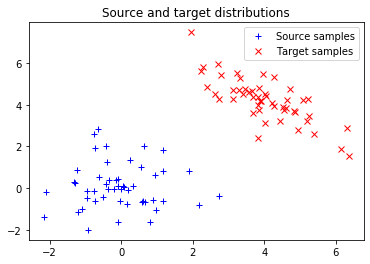

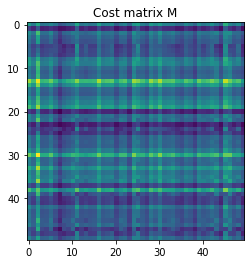

In [69]:
#%% plot samples

plt.figure(1)
plt.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
plt.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
plt.legend(loc=0)
plt.title('Source and target distributions')

plt.figure(2)
plt.imshow(M, interpolation='nearest')
plt.title('Cost matrix M')

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


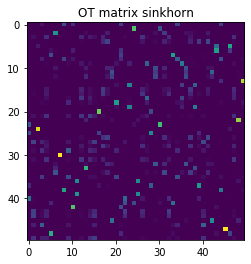

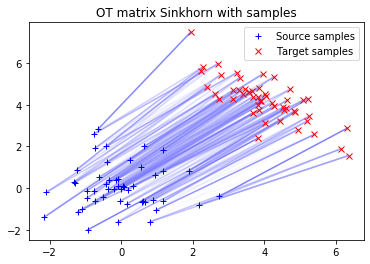

In [70]:
#%% sinkhorn

# reg term
lambd = 1e-3

Gs = ot.sinkhorn(a, b, M, lambd)

plt.figure(5)
plt.imshow(Gs, interpolation='nearest')
plt.title('OT matrix sinkhorn')

plt.figure(6)
ot.plot.plot2D_samples_mat(xs, xt, Gs, color=[.5, .5, 1])
plt.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
plt.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
plt.legend(loc=0)
plt.title('OT matrix Sinkhorn with samples')

plt.show()

In [ ]:
class BijectiveNet(nn.Module):
    def __init__(self):
        self.fc1 = nn.Linear(1,3)
        self.fc2 = nn.Linear(3,1)
        
    def forward(self, x):
        x = nn.Relu(self.fc1(x))
        return self.fc2(x)
        
model = BijectiveNet()
optimizer = torch.optim.Adam(model.parameters())

gt_fn = lambda x: x
domain = np.linspace(-100,100,1000)

for epoch in range(100):
    